In [1]:
# ylearn の因果モデルモジュールから CausalGraph / CausalModel をインポート
# - CausalGraph: 因果グラフ（DAG）の構造（ノードと矢印）を表現するクラス
# - CausalModel: 因果グラフに基づいて、因果効果の識別（ID）、バックドア集合の探索などを行うクラス
from ylearn.causal_model.graph import CausalGraph
from ylearn.causal_model.model import CausalModel

# ------------------------------------------------------------
# 因果グラフ（DAG）の構造定義
# ------------------------------------------------------------
# causation は「子ノード名: [その親ノードのリスト]」という形式で定義する。
# これは Pearl の因果モデルにおける有向非巡回グラフ（DAG）の親集合 pa(V) を
# そのまま Python の辞書で書き下したものと見ることができる。
#
# ノードの解釈（直感的なイメージ）:
# - X1, X2: 観測された背景要因（交絡因子候補）
# - X3, X4, X5: X1, X2 の影響を受ける中間変数／追加共変量
# - X: 介入したい「処置変数（treatment）」、ここから Y へ因果効果を知りたい
# - X6: X, X1, X2 の影響を受ける中間変数（Y への経路の一部）
# - Y: アウトカム（outcome）。X の因果効果を評価したい対象
#
# ここで重要なのは、X の親（X3, X4, X5）および Y の親（X3, X4, X5, X6, X）に
# どのような共通原因（交絡）・媒介経路があるかで、
# X -> Y の因果効果を識別するための「調整集合（backdoor set）」が決まること。
causation = {
    # X1 と X2 は親を持たない根ノード（外生変数）
    "X1": [],
    "X2": [],
    # X3 は X1 の子： X1 → X3
    "X3": ["X1"],
    # X4 は X1, X2 の子： X1 → X4, X2 → X4
    "X4": ["X1", "X2"],
    # X5 は X2 の子： X2 → X5
    "X5": ["X2"],
    # X6 は X, X1, X2 の子：
    # - X → X6 → Y という「X の媒介経路」の一部
    # - X1, X2 からも影響を受けるので、複雑な交絡／媒介構造を形成する
    "X6": ["X", "X1", "X2"],
    # X は X3, X4, X5 の子：
    # - X3, X4, X5 は X の決定要因（treatment の親）であり、
    #   これらが Y ともつながっていると、X と Y の間に交絡経路が生じうる
    "X": ["X3", "X4", "X5"],
    # Y は X3, X4, X5, X6, X の子：
    # - Y は X からの直接効果（X → Y）と、X6 などを介した間接効果、
    #   さらに X3, X4, X5 からの影響を同時に受けている
    "Y": ["X3", "X4", "X5", "X6", "X"],
}

# ------------------------------------------------------------
# CausalGraph オブジェクトの生成
# ------------------------------------------------------------
# CausalGraph は上で定義した causation 辞書を内部に取り込み、
# - ノード集合
# - 各ノードの親集合 pa(V)
# - networkx のグラフ表現
# などを保持するクラスである。
#
# この段階ではあくまで「構造だけ」を表現しており、
# まだ確率分布（P(X1, X2, ..., Y)）までは扱っていない。
cg = CausalGraph(causation=causation)

# ------------------------------------------------------------
# CausalModel の生成
# ------------------------------------------------------------
# CausalModel は CausalGraph をラップして、
# - バックドア集合の探索
# - フロントドア集合の探索
# - ID アルゴリズムによる P(Y | do(X)) の識別
# などを行う高レベル API を提供する。
#
# ここでは「X を介入変数 (treatment)」「Y をアウトカム (outcome)」とみなし、
# X -> Y の因果効果 P(Y | do(X)) をバックドア基準で識別できるかを調べる。
cm = CausalModel(causal_graph=cg)

# ------------------------------------------------------------
# バックドア基準に基づく調整集合（backdoor set）の探索
# ------------------------------------------------------------
# identify(
#   treatment={"X"},
#   outcome={"Y"},
#   identify_method=("backdoor", "simple")
# )
# は次を意味する：
#
# - treatment={"X"}:
#     介入対象の変数が X であることを指定。
#     「P(Y | do(X=x))」という因果効果を識別したい。
#
# - outcome={"Y"}:
#     因果効果の対象となるアウトカムが Y であることを指定。
#
# - identify_method=("backdoor", "simple"):
#     バックドア基準（Pearl）に基づいて、X -> Y の因果効果を
#     観測データの分布 P(·) の組み合わせとして表現しようとする。
#     "simple" は、候補となる調整集合のうち「単純な（最小に近い）もの」を返すモード。
#
# バックドア基準の理論（ざっくり）：
#   集合 Z が X から Y への因果効果に対する妥当な調整集合であるためには、
#   1. Z のどの要素も X の子孫でない
#   2. X と Y の間のすべての「バックドアパス」
#      （X に向かって矢印が入る形で始まるパス）が、
#      Z で条件付けることにより d-分離される
#
# そのとき因果効果は
#   P(y | do(x)) = Σ_z P(y | x, z) P(z)
# という形に書ける（z は backdoor set 上の値）。
#
# identify の戻り値は dict で、そのうち "backdoor" キーに
#   (backdoor_set, prob)
# が格納されている。
# - backdoor_set:
#     実際にバックドア基準を満たす調整集合（変数名のリスト）
# - prob:
#     P(Y | do(X)) を観測分布の関数として表現したオブジェクト（式）
backdoor_set, prob = cm.identify(
    treatment={"X"}, outcome={"Y"}, identify_method=("backdoor", "simple")
)["backdoor"]

# ------------------------------------------------------------
# 結果の解釈
# ------------------------------------------------------------
# backdoor_set に含まれる変数 Z で条件付けて推定を行えば、
# 理論的には「X の Y に対する純粋な因果効果」が識別可能になる。
#
# 具体的には、観測データ (X, Y, Z) を用いて
#   - 回帰モデル： E[Y | X, Z] を推定する
#   - 傾向スコアマッチング：e(X | Z) を推定して重み付けする
# などの手法と組み合わせることで、
# P(Y | do(X)) の推定を行うことができる。
#
# ここではまず、どの変数集合 Z が選ばれたのか（backdoor_set）を確認する。
print(backdoor_set)

['X3', 'X4', 'X5']


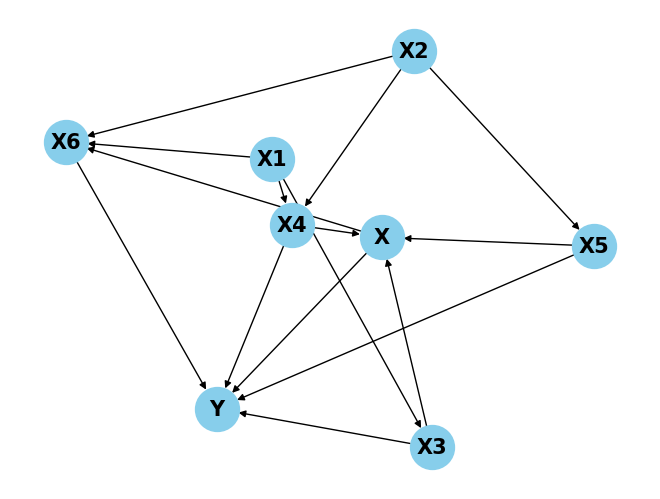

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

# ============================================================
# 因果グラフ（DAG）を可視化するコード
# ============================================================
# ここでは、すでに定義済みの `causation`（子ノード: 親ノードのリスト）
# から NetworkX の有向グラフ DiGraph を作り、
# 因果構造（どの変数がどの変数の原因か）を図として確認する。
#
# 可視化の目的：
# - 因果グラフの構造を直感的に理解する
# - バックドアパス・媒介経路・交絡因子などを
#   目視で確認しやすくする
# - モデルを組む前に DAG の妥当性をチェックする
# ============================================================

# 有向グラフ（Directed Graph）を作成
# DiGraph はノード間に向き付きの辺（A → B）を持てるグラフクラス。
# 因果グラフでは「原因 → 結果」の向きで矢印を表現する。
G = nx.DiGraph()

# ------------------------------------------------------------
# ノードの追加
# ------------------------------------------------------------
# causation のキーはすべての変数名（X1, X2, ..., Y）に対応している。
# それぞれをグラフのノードとして追加する。
for node in causation.keys():
    G.add_node(node)

# ------------------------------------------------------------
# 辺（エッジ）の追加
# ------------------------------------------------------------
# causation は
#   target: [source1, source2, ...]
# という形になっているので、
# 「source → target」という向きの有向辺を張る。
#
# 例：
#   "X3": ["X1"] なら X1 → X3
#   "Y": ["X3", "X4", "X5", "X6", "X"] なら
#       X3 → Y, X4 → Y, X5 → Y, X6 → Y, X → Y
for target, sources in causation.items():
    for source in sources:
        G.add_edge(source, target)

# ------------------------------------------------------------
# グラフのレイアウト計算と描画
# ------------------------------------------------------------
# pos = nx.spring_layout(G, seed=42)
# - spring_layout は「バネモデル」に基づくレイアウトで、
#   ノード間の距離が程よく分散するような位置を自動で決めてくれる。
# - seed を固定することで、毎回ほぼ同じ配置で描画され、
#   実験結果の再現性が保たれる。
pos = nx.spring_layout(G, seed=42)

# ノードラベル（ここではノード名そのままを表示）
labels = {node: node for node in G.nodes()}

# 実際の描画処理
# - labels: 各ノードに表示する文字列
# - with_labels=True: ノードの上にラベルを表示
# - node_color='skyblue': ノードの色
# - font_weight='bold': ラベル文字を太字に
# - node_size=1000: ノードの大きさ
# - font_size=15: ラベル文字のフォントサイズ
#
# この図を眺めることで、
# - X1, X2 がどのノードの親になっているか
# - X の親ノード（交絡候補）がどれか
# - Y への因果パスがどのように流れているか
# などを視覚的に確認できる。
nx.draw(
    G,
    pos,
    labels=labels,
    with_labels=True,
    node_color="skyblue",
    font_weight="bold",
    node_size=1000,
    font_size=15,
)

# 図を画面に表示
plt.show()